# Example for Adversarial attack

This notebook shows, how with relatively little code we can change the classification of a neural network without it being visible for humans.

In [1]:
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
import json
from tqdm import tqdm
%matplotlib inline

torch.manual_seed(210) # for reproducibility


### Download and setup model for evaluation mode

also show the labels we can classify. The pretrained models can distinguish 1000 classes, we are loading two different models. One Resnet based and one different architecture VGG16.


In [2]:
# use the labels for the imagenet data
labelsfile = "./labels.json"
data = ""
with open (labelsfile, "r") as myfile:
    data=myfile.read()
labels_json = json.loads(data)
labels = {int(idx):label for idx, label in labels_json.items()}

print(labels)


resnet = models.resnet34(pretrained=True) #download and load pretrained model
resnet.eval() # setting network to eval mode, to make sure we don't modify it's weights


# let's also have another model for verification...
net2 = models.vgg16(pretrained=True)
net2.eval()

#mean and std will remain same irresptive of the model you use
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

preprocess = transforms.Compose([
                transforms.Resize((224,224)),  
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

def classifyImage(network, image):
    output = network.forward(image)
    label_idx = torch.max(output.data, 1)[1][0]   #get an index(class number) of a largest element
    x_pred = labels[int(label_idx)]
    output_probs = F.softmax(output, dim=1)
    x_pred_prob =  (torch.max(output_probs.data, 1)[0][0]) * 100
    return (x_pred, x_pred_prob)




{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

In [3]:
# helper function to visualize an image tensor
def visualize(x):
    x = x.squeeze(0)     #remove batch dimension # B * C * H * W ==> C * H * W
    #reverse of normalization op- "unnormalize" - multiplication by std and adding of mean
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    # transpose to put channel last (like it is in regular rgb images)
    x = np.transpose( x , (1,2,0))   # C * H * W  ==>   H * W * C
    x = np.clip(x, 0, 1) 
    
    figure = plt.imshow(x)
    plt.show()

### Let's load an image we want to change the classification for

With everything prepared, let's now get a real image to work on

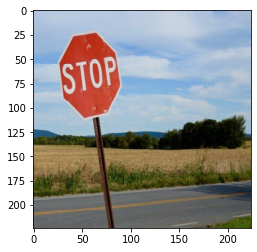

In [4]:
img = Image.open("stop.jpg")

image_tensor = preprocess(img) #preprocess an i
image_tensor = image_tensor.unsqueeze(0) # add batch dimension.  C X H X W ==> B X C X H X W
img_variable = Variable(image_tensor.clone(), requires_grad=True) #convert tensor into a variable

visualize(image_tensor)

### Classify the example
first of all, let's try the regular classification with the loaded neural network.


In [5]:
print(classifyImage(resnet, img_variable))
print(classifyImage(net2, img_variable))


('street sign', tensor(55.5840))
('street sign', tensor(40.9388))


The image is correctly classified as a street sign from both networks.
Good, now let's see what happens when we start changing the image.

### Adding noise to the image

First let's generate noise

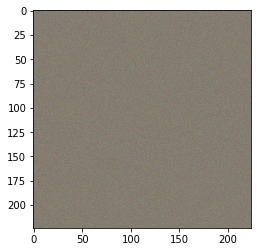

In [6]:
noise_image = 0.3 * torch.rand(img_variable.size())
visualize(noise_image)

### Now let's simply classify the noise alone

again let's use the loaded neural network model

In [7]:
print(classifyImage(resnet, noise_image))
print(classifyImage(net2, noise_image))

('wall clock', tensor(4.5388))
('wall clock', tensor(2.4095))


Both networks consolidated on the same class, but on a very low value. The same class is probably just luck or some bias in the data, but let's see what happens now, when we combine the original image with the noise.

### Now let's add this noise to the image

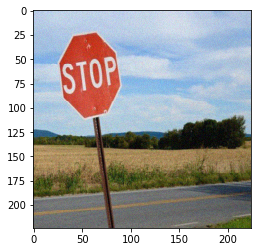

In [8]:
noisy_image = img_variable + noise_image
visualize(noisy_image.detach())

The new image looks not as clear as the original image, a bit grainy like camera noise, so let's now 

### Test how the classification will work on this noisy image



In [9]:
print(classifyImage(resnet, noisy_image))
print(classifyImage(net2, noisy_image))


('street sign', tensor(56.2734))
('street sign', tensor(31.2596))


**Image still classified as "street sign"**


even though there is visible distortion applied to the image, the image is still classified as a stop sign.
The model seems to be robust against distortion. Is that really the case?



### Idea: directed distortion

The problem with the approach above to fool the classificator is, that the noise is random and therefore kind of cancels itself out to some degree.

But we can do better, we can try to modify the noise in a certain direction

## Adversarial attack

If we iteratively move the _input_ slightly in a direction where the classification is closer to a different class, we can try to force the model to make a wrong decision.
For doing this we have all we need, since we know the model's internals. We can simply use gradients for this purpose.

So let's do the following: define a target class, compute the gradients with regard to the difference of the input image and the target (wrong) class, and then move slightly into the direction where the difference decreases.

This is a so called white box attack - since we know the parameters of the neural network.

Let's do this for 5 iterations in small steps.

In [10]:
epsilon = 0.02
num_steps = 5
alpha = 0.02

In [11]:
y_true = Variable( torch.LongTensor([808]), requires_grad=False)

for i in tqdm(range(num_steps)):
  zero_gradients(img_variable)                       # flush gradients for the img_variable
  output = resnet.forward(img_variable)              # perform forward pass on the known neural network
  loss = torch.nn.CrossEntropyLoss()                 # compute loss
  loss_cal = loss(output, y_true)
  loss_cal.backward()
  x_grad = alpha * torch.sign(img_variable.grad.data)   # as per the formula
  adv_temp = img_variable.data - x_grad                 # add perturbation to img_variable which also contains perturbation from previous iterations
  total_grad = adv_temp - img_variable                  # total perturbation
  total_grad = torch.clamp(total_grad, -epsilon, epsilon)
  x_adv = img_variable + total_grad                      #add total perturbation to the original image
  img_variable.data = x_adv


100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


The new constructed image was only slightly changed in these iterations, so let's look at the generated image in comparison to the original:

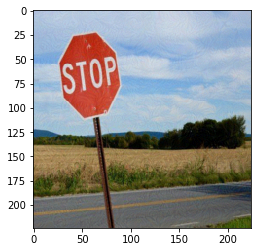

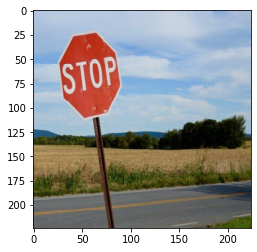

In [12]:
visualize (img_variable.detach())
visualize(image_tensor)

The images look pretty similar still, only small perturbations are visible for the human eye, so let's also look at the difference between original and modified image:

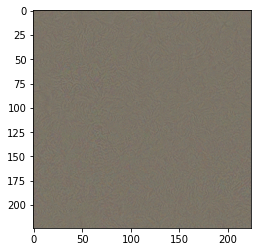

In [13]:
visualize(img_variable.detach() - image_tensor)

So how does our classificator do now on this changed image?

In [14]:
print(classifyImage(resnet, img_variable))

('sombrero', tensor(99.9972))


### Success
We were able to fool the classificator to see something else, while for a human the image looks almost the same.

### But
We knew the parameters of the network, is that a fair attack?

While it is certainly a good point against this kind of attack, often times it is indeed possible to get these parameters.
But even if we don't know the parameters, let's try, what another classificator would say, let's try a resnet50 classificator:

In [15]:
resnet50 = models.resnet50(pretrained=True) #download and load pretrained model
resnet50.eval() # setting network to eval mode, to make sure we don't modify it's weights
print(classifyImage(resnet50, img_variable))


('plastic bag', tensor(18.1589))


So even the deeper model is still fooled, without us having seen the weights of this model.
But maybe this was because of the similar architectures?

So we can try the same again on an architecture which is different from Resnet:

In [16]:
print(classifyImage(net2, img_variable)) # remember this is a vgg16 model!


('umbrella', tensor(19.0089))


## Conclusion

In this notebook we showed how comparably easy it is to fool a neural network in a classification task.
Obviously, the same approach can be used for other tasks, too.

It is also shown, that a whitebox attack might also be used as a surrogate for fooling other networks. Even networks, that are not very close from an architectural perspective.